In [23]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.optimizers import Adam

In [1]:
import numpy as np
import pandas as pd
import math as math
import cmath as cmath
from scipy.stats import norm
from scipy import integrate
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from xgboost import XGBClassifier
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Explicit solution of the Heston price equation <a class="anchor" id="solution"></a>
In this section, we define the functions needed to find the numberical solution:
$$ C(S,T) = S P_1 - K P_2 $$
More details in the report

In [2]:
# characteristic function
def f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
    
    a = kappa * theta
    x = math.log(s0)
    
    # remind that lamda is zero
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    d = cmath.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    
    C = r * phi * 1j * T + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * cmath.log((1 - g * cmath.exp(d * T))/(1 - g)))
    D = (b - rho * sigma * phi * 1j + d) / (sigma**2) * ((1 - cmath.exp(d * T)) / (1 - g * cmath.exp(d * T)))
    
    return cmath.exp(C + D * v0 + 1j * phi * x)

In [3]:
# P1 and P2
def p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    
    
    integrand = lambda phi: (cmath.exp(-1j * phi * cmath.log(K)) * f(phi, kappa, \
                              theta, sigma, rho, v0, r, T, s0, status) / (1j * phi)).real 
    
    return (0.5 + (1 / math.pi) * integrate.quad(integrand, 0, 100)[0]) # approximate indefinite intergral with a definite one

def p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)

def p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)


In [4]:
# call price
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    
    P1 = p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    P2 = p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    
    result = (s0 * P1 - K * math.exp(-r * T) * P2)
    
    if result<0 or k-s0>1: # negative result or initial price very very low with respect to k
        result = 0
        
    return result

# Stock paths generator <a class="anchor" id="stock"></a>
We define the functions needed to create the stock paths using the Heston model dynamic:


In [5]:
# generate the stock price simulation
def stock_price_generator (T, n , m, r, S0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=False ):
    dt = T / n
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
        
    if entire_stock==False: # return only the stocks simulation at T
        result = s[:,-1]; 
    else:
        result = s; # return all the stock dynamic
        
    return result
    

In [6]:
# find the stock price from ST as expected return
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

# Generate Data <a class="anchor" id="data"></a>

- [all values fixed apart S0](#data1)
- [all values fixed apart K](#data2)
- [all values fixed apart S0 and r](#data3)
- [all values fixed apart S0 and V0](#data4)
- [all values fixed apart S0, T and V0](#data5)

In [7]:
generator = np.random.default_rng()

**- All values fixed apart S0**

In [16]:
# set parameters and constants
r = 0
K = np.arange(0.5,4,0.05)
V0 = 0.01
sigma = 0.6
theta = 0.02
kappa = 6.21
rho = -0.5

s0 = 2

In [17]:
time_maturity = 3
num_simulations = 100
n = 250 # numbers of division of the time 

In [18]:
df3 = pd.DataFrame(columns=['k', 'price'])
num_price = []

In [19]:
# fill the dataset
for k in K:
    s = stock_price_generator (time_maturity, n, num_simulations, r, s0, k, V0, sigma, theta, kappa, rho, generator, entire_stock=True)

    for stock_path in s: # for each simulation
        price = find_expected_payoff(stock_path, k, r, time_maturity)
        num_price.append(call_price(kappa, theta, sigma, rho, V0, r, time_maturity, s0, k))
        
        new_row = {
                      'price':price, 
                      'k':k,
                  }
        #append row to the dataframe
        df3 = df3.append(new_row, ignore_index=True)

In [35]:
df3_class = pd.DataFrame()
df3_class['exercise'] = df3.price!=0
df3_class['k'] = df3.k
df3_class['price'] = df3.price
df3_class.head()

,exercise,k,price
0,True,0.5,1.297998
1,True,0.5,1.637903
2,True,0.5,1.893333
3,True,0.5,0.663243
4,True,0.5,1.571816


In [36]:
X_class = df3_class['k']
y_class = df3_class['exercise']

x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2)

In [37]:
x_train_class = x_train_class.values.reshape(-1, 1)
y_train_class = y_train_class.values.reshape(-1, 1)
x_test_class = x_test_class.values.reshape(-1, 1)

In [38]:
logreg3 = LogisticRegression()
logreg3.fit(x_train_class, y_train_class)

LogisticRegression()

In [39]:
df3_class['exercise_predict'] = logreg3.predict(df3_class['k'].values.reshape(-1, 1))

In [40]:
df3_class_linear = df3_class.loc[ df3_class['exercise_predict']==True ]
df3_class_linear.head()

,exercise,k,price,exercise_predict
0,True,0.5,1.297998,True
1,True,0.5,1.637903,True
2,True,0.5,1.893333,True
3,True,0.5,0.663243,True
4,True,0.5,1.571816,True


In [41]:
y = df3_class_linear.price
X = df3_class_linear.k

x_train_lin_cleaned, x_test_lin_cleaned, y_train_lin_cleaned, y_test_lin_cleaned = train_test_split(X, y, test_size=0.2)

In [42]:
x_train_lin_cleaned = x_train_lin_cleaned.values.reshape(-1, 1)
y_train_lin_cleaned = y_train_lin_cleaned.values.reshape(-1, 1)
x_test_lin_cleaned = x_test_lin_cleaned.values.reshape(-1, 1)

In [43]:
lin_clean3 = LinearRegression()
lin_clean3.fit(x_train_lin_cleaned, y_train_lin_cleaned)

LinearRegression()

In [44]:
price_pred_lin_cleaned3 = lin_clean3.predict(K.reshape(-1, 1))

In [46]:
price_log_lin_cleaned3 = []

for i in range(len(K)):
    if execute_log3[i]==0:
        price_log_lin_cleaned3.append(0)
    else:
        price_log_lin_cleaned3.append(price_pred_lin_cleaned3[i])    

In [52]:
num_price = []

for k in K:
    num_price.append(call_price(kappa, theta, sigma, rho, V0, r, time_maturity, s0, k))

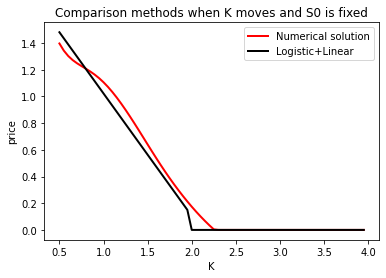

In [54]:
plt.plot(K, num_price, color='red', linewidth=2, label='Numerical solution')
plt.plot(K, price_log_lin_cleaned3, color='black', linewidth=2, label='Logistic+Linear') 
plt.legend()
plt.title("Comparison methods when K moves and S0 is fixed")
plt.xlabel("K")
plt.ylabel("price")
plt.show()

The above figure shows that the behaviour is similar to the case where S0 moves and K is fixed. However, the plot is a reflexion of the previous one. This makes sense because a low k means that the 